# Setup

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
sns.set_style('whitegrid')
sns.despine(right=True, top=True)
%matplotlib inline

# Riddler Express

You are playing your first ever game of “Ticket to Ride,” a board game in which players compete to lay down railroad while getting so competitive they risk ruining their marriages. At the start of the game, you are randomly dealt a set of three Destination Tickets out of a deck of 30 different tickets. Each reveals the two terminals you must connect with a railroad to receive points. During the game, you eventually pick up another set of three Destination Tickets, so you have now seen six of the 30 tickets in the game.

Later, because you enjoyed it so much, you and your friends play a second game. The ticket cards are all returned and reshuffled. Again, you are dealt a set of three tickets to begin play. Which is more likely: that you had seen at least one of these three tickets before, or that they were all new to you?

In [5]:
total_cards = 30
cards_seen = 24
prob_new_card = lambda k: (cards_seen - k) / (total_cards - k)

prob_all_new = 1

for i in range(3):
    prob_all_new *= prob_new_card(i)

print("Probability of being dealt three previously unseen cards:", round(prob_all_new, 4))
print("Probability of having seen at least one of the cards before:", round(1 - prob_all_new, 4))

Probability of being dealt three previously unseen cards: 0.4985
Probability of having seen at least one of the cards before: 0.5015


# Riddler Classic

You are competing in a spelling bee alongside nine other contestants. You can each spell words perfectly from a certain portion of the dictionary but will misspell any word not in that portion of the book. Specifically, you have 99 percent of the dictionary down cold, and your opponents have 98 percent, 97 percent, 96 percent, and so on down to 90 percent memorized. The bee’s rules are simple: The contestants take turns spelling in some fixed order, which then restarts with the first surviving speller at the end of a round. Miss a word and you’re out, and the last speller standing wins. The bee words are chosen randomly from the dictionary.

First, say the contestants go in decreasing order of their knowledge, so that you go first. What are your chances of winning the spelling bee? Second, say the contestants go in increasing order of knowledge, so that you go last. What are your chances of winning now?

## Solution A

Assuming that the contestants need to be reordered.

In [6]:
def spelling_bee_winners(best_player_starts=True, num_bees=10**3, to_percent=False):
    ''' Simulate spelling bees and return distribution of victories.'''
    
    players = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
    results = {name: 0 for name in players}

    # Simulate spelling bee
    for i in range(num_bees):

        names = players.copy()
        probs = [.9 + 0.01*i for i in range(10)]
        
        if best_player_starts:
            probs = probs[::-1]
        else:
            names = names[::-1]

        spelling_bee = OrderedDict([(name, prob) for name, prob in zip(names, probs)])

        # This is a round, restarts when player gets eliminated
        while len(spelling_bee) > 1:

            for player, prob in spelling_bee.items():

                # Sample a word from the dictionary
                word = np.random.uniform(size=1)

                # If player doesn't know word, remove from competition, reorder contestants and start new round
                if word > prob:
                    remove = names.index(player)

                    del names[remove]
                    del probs[remove]
                    
                    # Check if eliminated player is the last player
                    if len(names) - remove == 1:
                        spelling_bee = OrderedDict([(name, prob) for name, prob in zip(names, probs)])
                        break
                    else:
                        new_players = names[remove:] + names[:remove]
                        new_probs = probs[remove:] + probs[:remove]
                        spelling_bee = OrderedDict([(name, prob) for name, prob in zip(new_players, new_probs)])
                        break
        
        # Record victory for winning player
        for player in spelling_bee.keys():
            results[player] += 1
        
    # Convert score to percent
    if to_percent:
        for player in results.keys():
            results[player] = results[player] * (1 / num_bees)
    
    return results

In [7]:
def simulations(num_bees=10**3, simulations=100, best_player_starts=True, to_percent=False):
    ''' Simulate spelling bees to get average and std. deviations. '''
    results = np.zeros(simulations)
    for i in range(simulations):
        best_first = spelling_bee_winners(best_player_starts=best_player_starts, num_bees=num_bees, to_percent=to_percent)
        results[i] = best_first['A']
    return results

def plot_results(results, bins=20, title=None):
    ''' Helper function to plot results of simulations.'''
    average = np.mean(results)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(results, bins=bins, alpha=0.8)
    ax.axvline(average, linestyle="--", color="k", label=f"Average: {average}")
    ax.legend()
    if title:
        ax.set_title(title, size=20)
    plt.show()
    
def two_plot_results(results, bins=20, label=None):
    ''' Helper function to plot results of simulations.'''
    average = round(np.mean(results), 4)
    plt.hist(results, bins=bins, alpha=0.7, label=f'{label} (avg.: {average})')
    plt.axvline(average, linestyle="--", color='k')

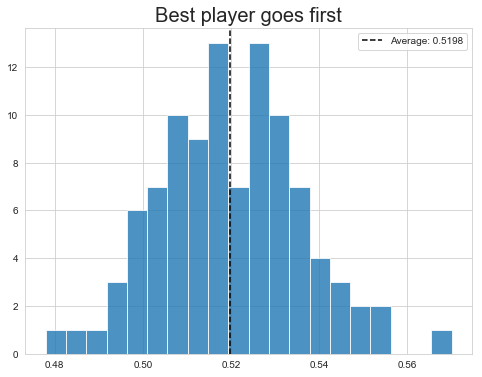

In [9]:
results_best_first = simulations(best_player_starts=True, to_percent=True)
plot_results(results_best_first, title="Best player goes first")

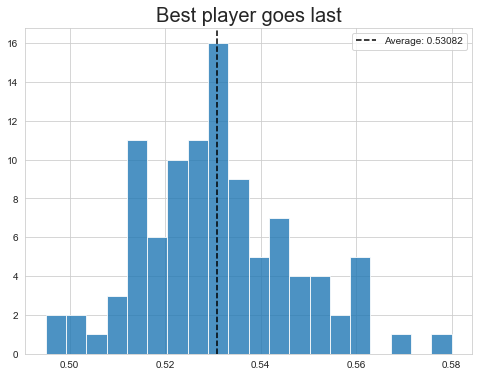

In [10]:
results_best_last = simulations(best_player_starts=False, to_percent=True)
plot_results(results_best_last, title="Best player goes last")

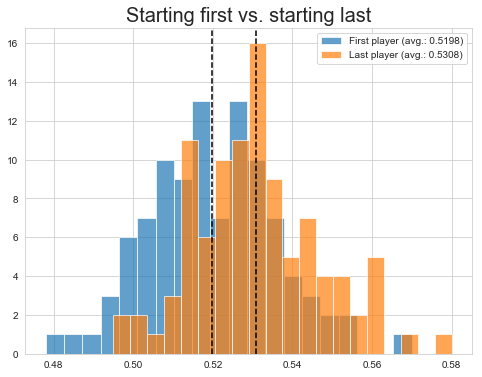

In [11]:
# Plotting comparisons
plt.figure(figsize=(8, 6))
two_plot_results(results_best_first, label='First player')
two_plot_results(results_best_last, label='Last player')
plt.title('Starting first vs. starting last', size=20)
plt.legend()
plt.show()

## Solution B:

Assuming that the contestants do not need to be reordered.

In [8]:
def spelling_bee_winners(best_player_starts=True, num_bees=10**3, to_percent=False):
    ''' Simulate spelling bees and return distribution of victories.'''
    
    players = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
    results = {name: 0 for name in players}

    # Simulate spelling bee
    for i in range(num_bees):

        names = players.copy()
        probs = [.9 + 0.01*i for i in range(10)]
        
        if best_player_starts:
            probs = probs[::-1]
        else:
            names = names[::-1]

        spelling_bee = OrderedDict([(name, prob) for name, prob in zip(names, probs)])

        # This is a round, restarts when player gets eliminated
        while len(spelling_bee) > 1:

            for player, prob in spelling_bee.items():

                # Sample a word from the dictionary
                word = np.random.uniform(size=1)

                # If player doesn't know word, remove from competition, reorder contestants and start new round
                if word > prob:
                    remove = names.index(player)
                    del names[remove]
                    del probs[remove]
                    spelling_bee = OrderedDict([(name, prob) for name, prob in zip(names, probs)])
                    break
                    
        # Record victory for winning player
        for player in spelling_bee.keys():
            results[player] += 1
        
    # Convert score to percent
    if to_percent:
        for player in results.keys():
            results[player] = results[player] * (1 / num_bees)
    
    return results

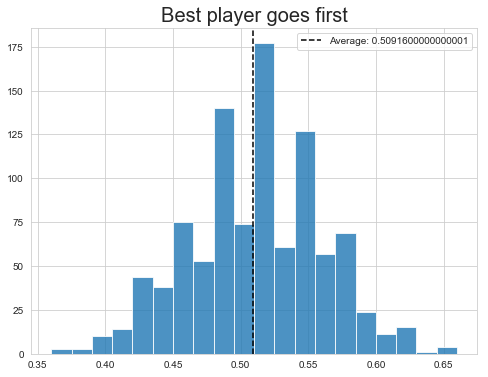

In [12]:
results_best_first = simulations(best_player_starts=True, to_percent=True, num_bees=100, simulations=1000)
plot_results(results_best_first, title="Best player goes first")

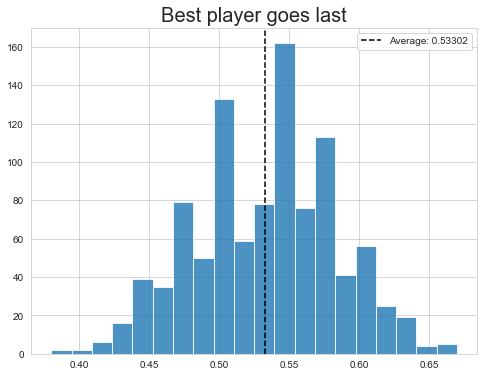

In [13]:
results_best_last = simulations(best_player_starts=False, to_percent=True, num_bees=100, simulations=1000)
plot_results(results_best_last, title="Best player goes last")

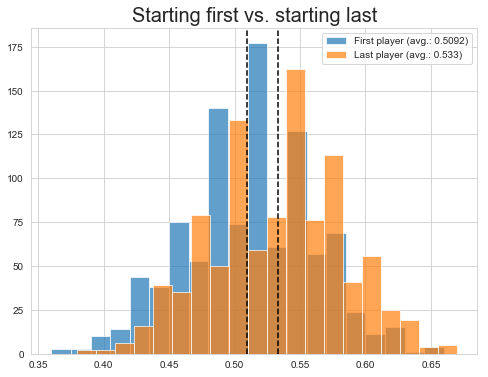

In [14]:
# Plotting comparisons
plt.figure(figsize=(8, 6))
two_plot_results(results_best_first, label='First player')
two_plot_results(results_best_last, label='Last player')
plt.title('Starting first vs. starting last', size=20)
plt.legend()
plt.show()